# AqSolDB Project 1 – Aqueous Solubility from RDKit Descriptors

**Goal:** Build and analyze baseline machine learning models to predict aqueous solubility (logS) for organic molecules in AqSolDB using RDKit descriptors.

**Plan:**  
1. Load AqSolDB and create RDKit `Mol` objects.
2. Compute RDKit descriptors and clean the feature matrix.
3. Train/validate a Random Forest baseline on descriptors (v1).
4. Explore alternative representations/models:
   - v2: Morgan fingerprints + RF
   - v3: Descriptors + Gradient Boosting
   - NN side experiment: small MLP on descriptors
5. Perform a brief scientific error analysis on the best model.
6. Summarize conclusions and possible next steps.

# Data Source
**Sorkun, M.C., Khetan, A. & Er, S. AqSolDB, a curated reference set of aqueous solubility and 2D descriptors for a diverse set of compounds. Sci Data 6, 143 (2019).**

**Nature Scientific Data - https://doi.org/10.1038/s41597-019-0151-1**

# Environment Setup

In [1]:
pip download rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.6 MB/s eta 0:00:00
Saved ./rdkit-2025.9.5-cp312-cp312-manylinux_2_28_x86_64.whl
Saved ./numpy-2.4.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl
Saved ./pillow-12.1.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl
Successfully downloaded rdkit numpy Pillow
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install /kaggle/working/rdkit*.whl

Processing ./rdkit-2025.9.5-cp312-cp312-manylinux_2_28_x86_64.whl


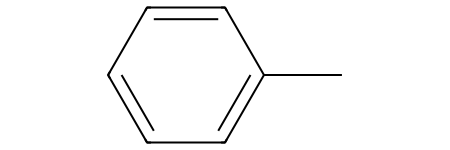

In [3]:
# confirm rdkit installation
from rdkit import Chem
Chem.MolFromSmiles("Cc1ccccc1")

# Package loading

In [4]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Initial Data Loading & Analysis

## Load csv and verify head

In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

path = '/kaggle/input/aqsoldb-a-curated-aqueous-solubility-dataset/curated-solubility-dataset.csv'
df = pd.read_csv(path)
df.head()

/kaggle/input/aqsoldb-a-curated-aqueous-solubility-dataset/curated-solubility-dataset.csv


,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


## Column info and target histogram

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9982 entries, 0 to 9981
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9982 non-null   object 
 1   Name                 9982 non-null   object 
 2   InChI                9982 non-null   object 
 3   InChIKey             9982 non-null   object 
 4   SMILES               9982 non-null   object 
 5   Solubility           9982 non-null   float64
 6   SD                   9982 non-null   float64
 7   Ocurrences           9982 non-null   int64  
 8   Group                9982 non-null   object 
 9   MolWt                9982 non-null   float64
 10  MolLogP              9982 non-null   float64
 11  MolMR                9982 non-null   float64
 12  HeavyAtomCount       9982 non-null   float64
 13  NumHAcceptors        9982 non-null   float64
 14  NumHDonors           9982 non-null   float64
 15  NumHeteroatoms       9982 non-null   f

In [7]:
df['Solubility'].describe()

count    9982.000000
mean       -2.889909
std         2.368154
min       -13.171900
25%        -4.326325
50%        -2.618173
75%        -1.209735
max         2.137682
Name: Solubility, dtype: float64

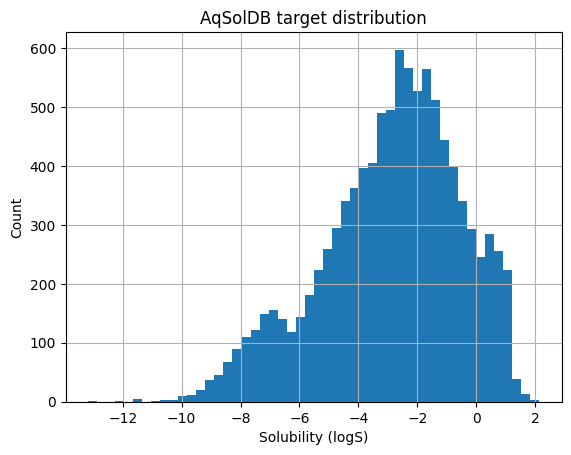

In [8]:
df['Solubility'].hist(bins=50)
plt.xlabel('Solubility (logS)')
plt.ylabel('Count')
plt.title('AqSolDB target distribution')
plt.show()

## Conversion: SMILES → Mol

In [9]:
def smiles_to_mol(s):
    if pd.isna(s):
        return None
    return Chem.MolFromSmiles(s)

df['mol'] = df['SMILES'].map(smiles_to_mol)
bad = df['mol'].isna().sum()
len_df = len(df)
bad, len_df

[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not removing hydrogen atom without neighbors
[19:13:10] WARNING: not r

(np.int64(2), 9982)

## Create df2, deleting invalid molecules from SMILES conversion

In [10]:
df2 = df.dropna(subset=['mol']).copy()
df2.shape

(9980, 27)

## Check: show a molecule

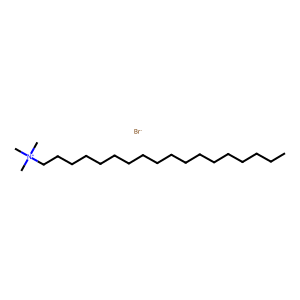

In [11]:
example_mol = df2['mol'].iloc[0]
Draw.MolToImage(example_mol)

##  Compute RDKit descriptors for df2

In [12]:
# list of descriptor names and functions
desc_names = [d[0] for d in Descriptors._descList]
desc_funcs = [d[1] for d in Descriptors._descList]

def calc_descriptors(m):
    return [f(m) for f in desc_funcs]

# apply to each mol
X_desc = df2['mol'].map(calc_descriptors)

# turn into DataFrame
X = pd.DataFrame(X_desc.tolist(), columns=desc_names)

# create target
y = df2['Solubility']

X.shape, y.shape

[19:13:14] WARNING: not removing hydrogen atom without neighbors
[19:13:15] WARNING: not removing hydrogen atom without neighbors
[19:13:15] WARNING: not removing hydrogen atom without neighbors
[19:13:17] WARNING: not removing hydrogen atom without neighbors
[19:13:18] WARNING: not removing hydrogen atom without neighbors
[19:13:18] WARNING: not removing hydrogen atom without neighbors
[19:13:19] WARNING: not removing hydrogen atom without neighbors
[19:13:19] WARNING: not removing hydrogen atom without neighbors
[19:13:19] WARNING: not removing hydrogen atom without neighbors
[19:13:20] WARNING: not removing hydrogen atom without neighbors
[19:13:20] WARNING: not removing hydrogen atom without neighbors
[19:13:21] WARNING: not removing hydrogen atom without neighbors
[19:13:31] WARNING: not removing hydrogen atom without neighbors
[19:13:31] WARNING: not removing hydrogen atom without neighbors
[19:13:31] WARNING: not removing hydrogen atom without neighbors
[19:13:31] WARNING: not r

((9980, 217), (9980,))

## Clean up NaN / inf and clip extremes

In [13]:
# ensure numeric
X = X.apply(pd.to_numeric, errors="coerce")

# replace ±inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# clip extreme values to avoid overflow
X = X.clip(lower=-1e6, upper=1e6)

# verify
print(f'Number of infinities: {np.isinf(X.to_numpy()).sum()} \nNumber of NANs: {np.isnan(X.to_numpy()).sum()}')

Number of infinities: 0 
Number of NANs: 7478


In [14]:
# check for NANs by column
X.isna().sum().sort_values(ascending=False).head(20)

BCUT2D_CHGLO           884
BCUT2D_LOGPLOW         884
BCUT2D_MWHI            884
BCUT2D_CHGHI           884
BCUT2D_MWLOW           884
BCUT2D_MRHI            884
BCUT2D_LOGPHI          884
BCUT2D_MRLOW           884
MaxPartialCharge       102
MaxAbsPartialCharge    102
MinPartialCharge       101
MinAbsPartialCharge    101
ExactMolWt               0
qed                      0
MinEStateIndex           0
MinAbsEStateIndex        0
SPS                      0
MaxAbsEStateIndex        0
HeavyAtomMolWt           0
MolWt                    0
dtype: int64

### The largest values are ~9% and could be removed, but this is my first project so I will impute these instead of removing them for now.

## Impute NANs

In [15]:
imputer = SimpleImputer(strategy="median")
X_imputed_array = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns, index=X.index)

# quick check
np.isnan(X_imputed.to_numpy()).sum()  # should be 0

np.int64(0)

In [16]:
X_imputed.isna().sum().sort_values(ascending=False).head(20)

MaxAbsEStateIndex      0
MaxEStateIndex         0
MinAbsEStateIndex      0
MinEStateIndex         0
qed                    0
SPS                    0
MolWt                  0
HeavyAtomMolWt         0
ExactMolWt             0
NumValenceElectrons    0
NumRadicalElectrons    0
MaxPartialCharge       0
MinPartialCharge       0
MaxAbsPartialCharge    0
MinAbsPartialCharge    0
FpDensityMorgan1       0
FpDensityMorgan2       0
FpDensityMorgan3       0
BCUT2D_MWHI            0
BCUT2D_MWLOW           0
dtype: int64

# v1 Model Based on Descriptors

## Train/valid split + RF baseline

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_imputed.astype(np.float64), y,
    test_size=0.2,
    random_state=42
)

model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), # left this in as a reminder of its utility
    ("rf", RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)
pred = model.predict(X_valid)

mae = mean_absolute_error(y_valid, pred)
rmse = np.sqrt(mean_squared_error(y_valid, pred))
r2 = r2_score(y_valid, pred)

print(f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR2: {r2:.4f}')

MAE: 0.6512
RMSE: 0.9633
R2: 0.8288


## Scatter plot

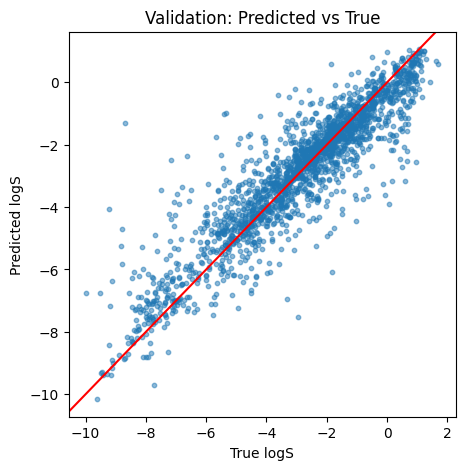

In [18]:
plt.figure(figsize=(5,5))
plt.scatter(y_valid, pred, s=10, alpha=0.5)
plt.xlabel("True logS")
plt.ylabel("Predicted logS")
plt.title("Validation: Predicted vs True")
plt.axline((0,0), slope=1, color="red")
plt.show()

## Build a results DataFrame

In [19]:
res = pd.DataFrame({
    "y_true": y_valid,
    "y_pred": pred
})
res["err"] = res["y_pred"] - res["y_true"]
res[["y_true", "y_pred", "err"]].describe()

,y_true,y_pred,err
count,1996.000000,1996.000000,1996.000000
mean,-2.895634,-2.856464,0.039170
std,2.329013,2.089613,0.962777
min,-9.979900,-10.158310,-4.543540
25%,-4.349925,-4.127546,-0.404904
50%,-2.568485,-2.508927,0.018287
75%,-1.240600,-1.379507,0.453926
max,1.700916,1.060430,7.399841


## Attach SMILES and mol to the validation set

In [20]:
res["SMILES"] = df2.loc[res.index, "SMILES"]
res["mol"] = df2.loc[res.index, "mol"]

# verify
res.head()

,y_true,y_pred,err,SMILES,mol
1253,-5.984242,-4.461657,1.522585,CCc1ccc2C(=O)c3ccccc3C(=O)c2c1,<rdkit.Chem.rdchem.Mol object at 0x7f5033070c80>
8226,-1.930000,-1.788615,0.141385,CCCCOC(=O)[N]1C=NC2=C1C(=O)N(C)C(=O)N2C,<rdkit.Chem.rdchem.Mol object at 0x7f5032f75150>
1658,-7.300465,-6.464642,0.835823,CC(=O)OCCN(CCOC(C)=O)c1ccc(cc1)N=Nc2ccc(cc2C#N...,<rdkit.Chem.rdchem.Mol object at 0x7f5033083ed0>
7735,-3.590000,-3.746596,-0.156596,CCCCCCCC(=O)N(C)C1=CC=C(C=C1)[S](=O)(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x7f5032f678b0>
1441,-4.340909,-6.246291,-1.905382,CC(=O)OCCN(CCC#N)c1ccc(cc1)N=Nc2sc3cc(ccc3n2)[...,<rdkit.Chem.rdchem.Mol object at 0x7f5033075f50>


## Extract the 10 worst predictions

In [21]:
worst10 = res.loc[res["err"].abs().nlargest(10).index].copy()
worst10[["y_true", "y_pred", "err", "SMILES"]]

,y_true,y_pred,err,SMILES
3646,-8.702012,-1.302171,7.399841,[Zr++].CCCCC(CC)C([O-])=O.CCCCC(CC)C([O-])=O
3555,-9.219530,-4.051013,5.168517,CCOC(=O)OCCOc1cc(O)c2C(=O)c3ccccc3C(=O)c2c1N
1662,-7.155088,-2.495712,4.659376,[NH4+].[Fe++].[Fe+3].[C-]#N.[C-]#N.[C-]#N.[C-]...
8345,-2.970000,-7.513540,-4.543540,C1CC2=CC3=CC4=C(C=CC=C4)C=C3C5=C2C1=CC=C5
1516,-5.392553,-1.018599,4.373954,[NH4+].[Mn+3].[O-][P]([O-])(=O)O[P]([O-])([O-])=O
3508,-5.347978,-0.977384,4.370594,[Co++].CCCCC(CC)C([O-])=O.CCCCC(CC)C([O-])=O
135,-1.825456,-6.086960,-4.261504,CCCCC(CC)C(=O)O[Co]OB(O[Co])O[Co](OC(=O)C(CC)C...
92,-6.619712,-2.363416,4.256296,[Pb++].[O-][Si]([O-])=O
3647,-8.782716,-4.705204,4.077512,CN1C(=O)C(=N/Nc2cccc(O[S](=O)(=O)c3ccccc3)c2)\...
1315,-7.505542,-3.462458,4.043084,COc1ccc(cc1O)C2=CC(=O)c3c(O)cc(O[C@@H]4O[C@H](...


## Visualize 10 worst predicted molecules

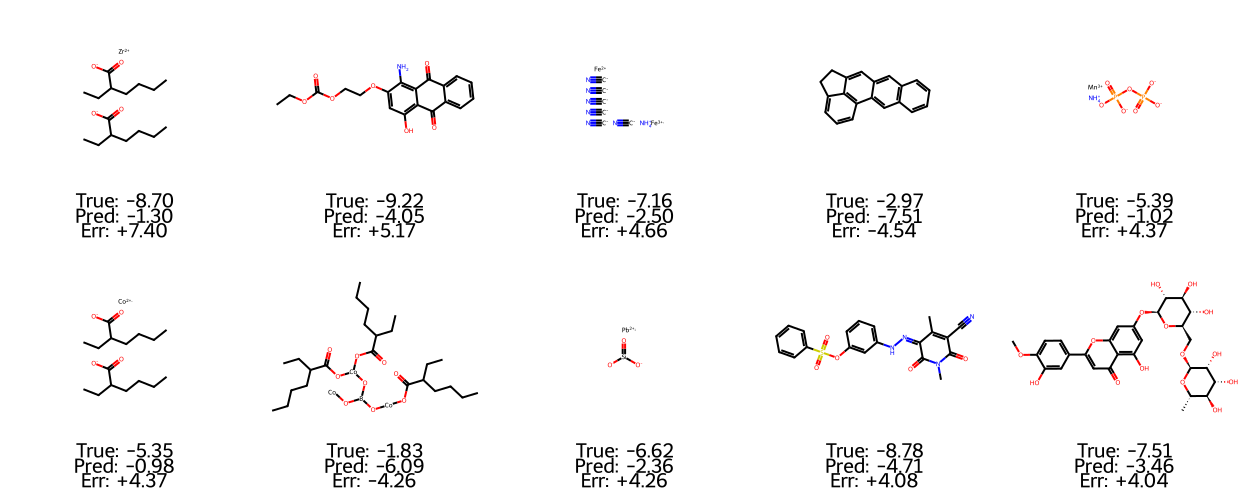

In [22]:
labels = [
    f"True: {t:.2f}\nPred: {p:.2f}\nErr: {e:+.2f}"
    for t, p, e in zip(worst10["y_true"], worst10["y_pred"], worst10["err"])
]

opts = Draw.MolDrawOptions()
opts.legendFontSize = 20
opts.legendFraction = 0.25 

img = Draw.MolsToGridImage(
    worst10["mol"].tolist(),
    molsPerRow=5,
    subImgSize=(250, 250),
    legends=labels,
    drawOptions=opts,
)
img

# v2 Model - Morgan fingerprints + RF

## 1. Build Morgan fingerprint features (radius 2, 2048 bits)

In [23]:
def mol_to_morgan_fp(mol, radius=2, n_bits=2048):
    if mol is None:
        return np.zeros(n_bits, dtype=int)
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    fp = gen.GetFingerprint(mol)
    arr = np.zeros((n_bits,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

X_fp_array = np.stack(df2["mol"].map(mol_to_morgan_fp).values)
X_fp = pd.DataFrame(X_fp_array)
y = df2["Solubility"]

## 2. Train/validation split (keep same random_state for comparability)

In [24]:
X_train_fp, X_valid_fp, y_train_fp, y_valid_fp = train_test_split(
    X_fp,
    y,
    test_size=0.2,
    random_state=42,
)

## 3. RF model on fingerprints + simple imputer (just in case)

In [25]:
rf_fp = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    )),
])

rf_fp.fit(X_train_fp, y_train_fp)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('rf',
                 RandomForestRegressor(n_estimators=400, n_jobs=-1,
                                       random_state=42))])

## 4. Metrics for fingerprint model

In [26]:
pred_fp = rf_fp.predict(X_valid_fp)

mae_fp = mean_absolute_error(y_valid_fp, pred_fp)
rmse_fp = np.sqrt(mean_squared_error(y_valid_fp, pred_fp))
r2_fp = r2_score(y_valid_fp, pred_fp)

print(f'MAE_fp: {mae_fp:.4f}\nRMSE_fp: {rmse_fp:.4f}\nR_fp2: {r2_fp:.4f}')

MAE_fp: 0.9131
RMSE_fp: 1.2839
R_fp2: 0.6960


## 5. Side‑by‑side comparison with descriptor baseline (v1)

In [27]:
results_compare = pd.DataFrame({
    "model": ["v1_descriptors_RF", "v2_fingerprints_RF"],
    "MAE": [mae, mae_fp],
    "RMSE": [rmse, rmse_fp],
    "R2": [r2, r2_fp],
})
results_compare

,model,MAE,RMSE,R2
0,v1_descriptors_RF,0.651181,0.963332,0.828831
1,v2_fingerprints_RF,0.913070,1.283889,0.695961


## 6. Error table for fingerprint model

In [28]:
res_fp = pd.DataFrame({
    "y_true": y_valid_fp,
    "y_pred": pred_fp,
})
res_fp["err"] = res_fp["y_pred"] - res_fp["y_true"]
res_fp["SMILES"] = df2.loc[res_fp.index, "SMILES"]
res_fp["mol"] = df2.loc[res_fp.index, "mol"]

worst10_fp = res_fp.loc[res_fp["err"].abs().nlargest(10).index].copy()
worst10_fp.head()

,y_true,y_pred,err,SMILES,mol
1662,-7.155088,-0.378931,6.776158,[NH4+].[Fe++].[Fe+3].[C-]#N.[C-]#N.[C-]#N.[C-]...,<rdkit.Chem.rdchem.Mol object at 0x7f5033090120>
3646,-8.702012,-2.151556,6.550456,[Zr++].CCCCC(CC)C([O-])=O.CCCCC(CC)C([O-])=O,<rdkit.Chem.rdchem.Mol object at 0x7f5032ef6c70>
1760,0.179474,-5.894097,-6.073571,CCCCCCCC(=O)OCC(O)CO,<rdkit.Chem.rdchem.Mol object at 0x7f5033092c70>
2045,0.057189,-5.860789,-5.917978,OCCOCCOCCCNc1ccc(NCCCOCCOCCO)c2C(=O)c3ccccc3C(...,<rdkit.Chem.rdchem.Mol object at 0x7f503309a9d0>
1671,-7.663344,-1.747057,5.916287,NC(Cc1ccccc1)=CC(=O)[C@@H](Cc2ccccc2)N(Cc3cccc...,<rdkit.Chem.rdchem.Mol object at 0x7f5033090510>


## 7. Visualize worst‑10 for fingerprint model

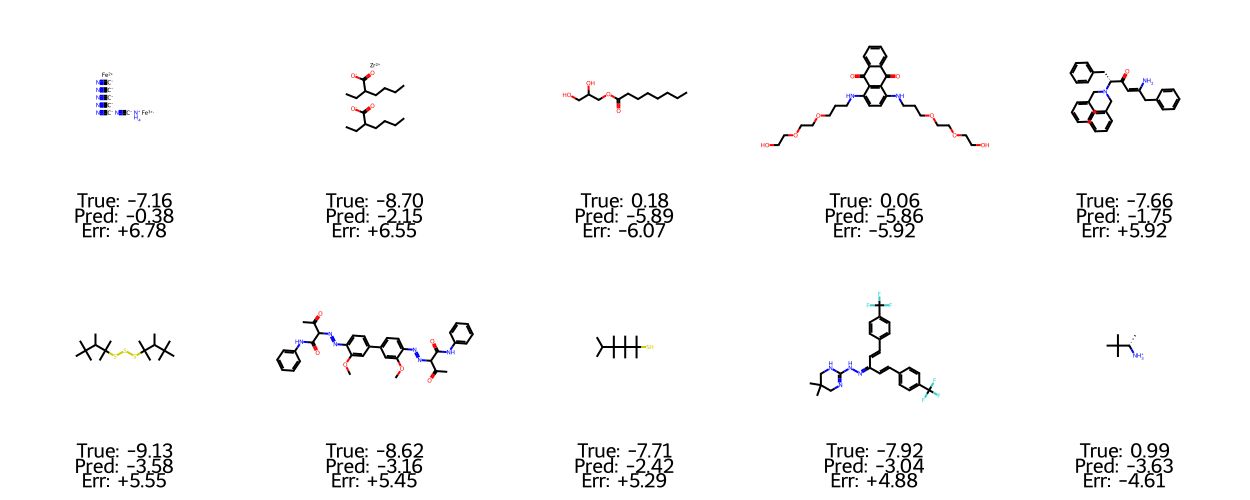

In [29]:
labels_fp = [
    f"True: {t:.2f}\nPred: {p:.2f}\nErr: {e:+.2f}"
    for t, p, e in zip(
        worst10_fp["y_true"], worst10_fp["y_pred"], worst10_fp["err"]
    )
]

opts = Draw.MolDrawOptions()
opts.legendFontSize = 20
opts.legendFraction = 0.25 

img_fp = Draw.MolsToGridImage(
    worst10_fp["mol"].tolist(),
    molsPerRow=5,
    subImgSize=(250, 250),
    legends=labels_fp,
    drawOptions=opts,
)
img_fp

# v3 Model: Descriptors + GradientBoosting (GBM)

## 1. Import and define the model

In [30]:
gbm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("gb", GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    )),
])

gbm.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('gb',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=500,
                                           random_state=42, subsample=0.8))])

## 2. Evaluate on the validation set

In [31]:
pred_gbm = gbm.predict(X_valid)

mae_gbm = mean_absolute_error(y_valid, pred_gbm)
rmse_gbm = np.sqrt(mean_squared_error(y_valid, pred_gbm))
r2_gbm = r2_score(y_valid, pred_gbm)

print(f'MAE_gbm: {mae_gbm:.4f}\nRMSE_gbm: {rmse_gbm:.4f}\nR2_gbm: {r2_gbm:.4f}')

MAE_gbm: 0.7023
RMSE_gbm: 1.0034
R2_gbm: 0.8143


## 3. Compare with existing models

In [32]:
results_all = pd.DataFrame({
    "model": [
        "v1_descriptors_RF_base",
        "v2_fingerprints_RF_base",
        "v3_descriptors_GBM",
    ],
    "MAE":  [mae, mae_fp, mae_gbm],
    "RMSE": [rmse, rmse_fp, rmse_gbm],
    "R2":   [r2, r2_fp, r2_gbm],
})

results_all

,model,MAE,RMSE,R2
0,v1_descriptors_RF_base,0.651181,0.963332,0.828831
1,v2_fingerprints_RF_base,0.913070,1.283889,0.695961
2,v3_descriptors_GBM,0.702270,1.003413,0.814291


# Scientific Error Analysis with the RF model

## 1. Predicted vs true logS scatter plot (RF baseline)

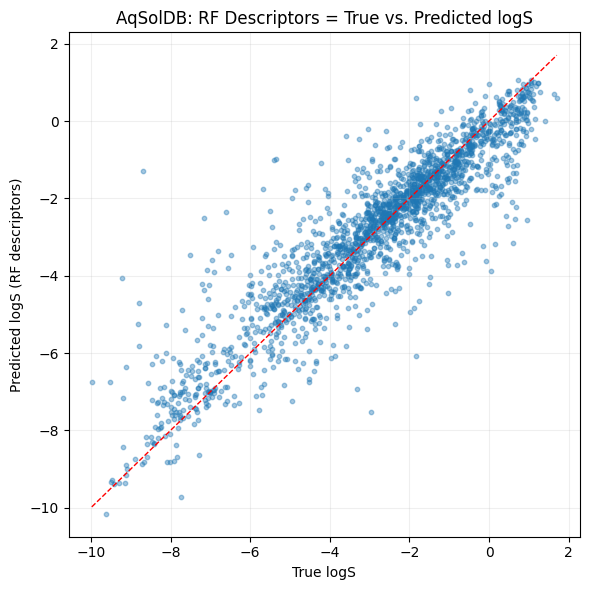

In [33]:
# recompute predictions for RF baseline
pred_rf = model.predict(X_valid)

plt.figure(figsize=(6,6))
plt.scatter(y_valid, pred_rf, alpha=0.4, s=10)
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
          color="red", linestyle="--", linewidth=1)
plt.xlabel('True logS')
plt.ylabel('Predicted logS (RF descriptors)')
plt.title('AqSolDB: RF Descriptors = True vs. Predicted logS')
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.show()

## 2. Build a reusable RF error DataFrame

In [34]:
res = pd.DataFrame({
    "y_true": y_valid,
    "y_pred": pred
})
res["err"] = res["y_pred"] - res["y_true"]
res[["y_true", "y_pred", "err"]].describe()

,y_true,y_pred,err
count,1996.000000,1996.000000,1996.000000
mean,-2.895634,-2.856464,0.039170
std,2.329013,2.089613,0.962777
min,-9.979900,-10.158310,-4.543540
25%,-4.349925,-4.127546,-0.404904
50%,-2.568485,-2.508927,0.018287
75%,-1.240600,-1.379507,0.453926
max,1.700916,1.060430,7.399841


In [35]:
res["SMILES"] = df2.loc[res.index, "SMILES"]
res["mol"] = df2.loc[res.index, "mol"]

# check
res.head()

,y_true,y_pred,err,SMILES,mol
1253,-5.984242,-4.461657,1.522585,CCc1ccc2C(=O)c3ccccc3C(=O)c2c1,<rdkit.Chem.rdchem.Mol object at 0x7f5033070c80>
8226,-1.930000,-1.788615,0.141385,CCCCOC(=O)[N]1C=NC2=C1C(=O)N(C)C(=O)N2C,<rdkit.Chem.rdchem.Mol object at 0x7f5032f75150>
1658,-7.300465,-6.464642,0.835823,CC(=O)OCCN(CCOC(C)=O)c1ccc(cc1)N=Nc2ccc(cc2C#N...,<rdkit.Chem.rdchem.Mol object at 0x7f5033083ed0>
7735,-3.590000,-3.746596,-0.156596,CCCCCCCC(=O)N(C)C1=CC=C(C=C1)[S](=O)(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x7f5032f678b0>
1441,-4.340909,-6.246291,-1.905382,CC(=O)OCCN(CCC#N)c1ccc(cc1)N=Nc2sc3cc(ccc3n2)[...,<rdkit.Chem.rdchem.Mol object at 0x7f5033075f50>


In [36]:
# attach desired key descriptors for analysis
for col in ['MolLogP', 'TPSA','MolWt']:
    if col in df2.columns:
        res[col] = df2.loc[res.index, col]

In [37]:
# attach key descriptors
key_descs = ['MolLogP', 'TPSA', 'MolWt']

for col in key_descs:
    if col in df2.columns:
        res[col] = df2.loc[res.index, col]
    else:
        print(f'{col} not found in df2.columns')

## 2. Plot error vs each descriptor

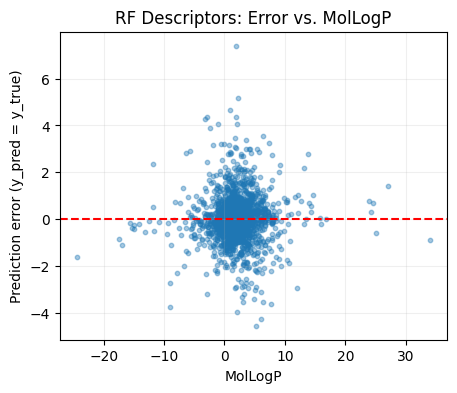

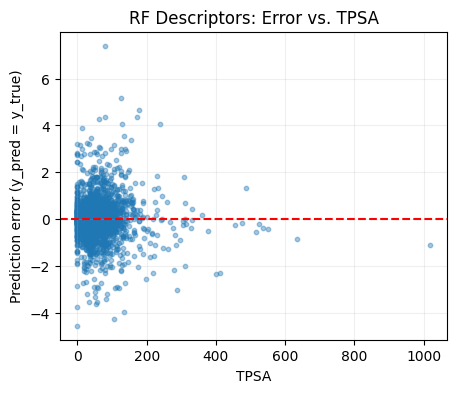

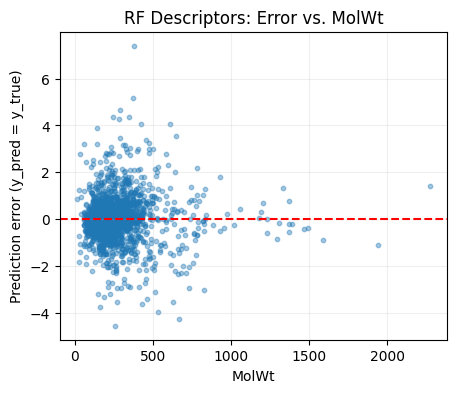

In [38]:
def plot_error_vs_feature(res, feature, err_col='err'):
    if feature not in res.columns:
        print(f'{feature} not in result DataFrame; skipping.')
        return

    plt.figure(figsize=(5,4))
    plt.scatter(res[feature], res[err_col], alpha=0.4, s=10)
    plt.axhline(0.0, color='red', linestyle='--', linewidth=1.5)
    plt.xlabel(feature)
    plt.ylabel('Prediction error (y_pred = y_true)')
    plt.title(f'RF Descriptors: Error vs. {feature}')
    plt.grid(True, alpha=0.2)
    plt.show()
    
for feature in key_descs:
    plot_error_vs_feature(res, feature)

# Scientific error analysis (RF)

- Predicted vs true logS shows a tight diagonal, with the largest residuals at very low solubility (logS ≲ −7).

- Error vs MolLogP, TPSA, and MolWt does not show strong systematic bias, though variance grows for heavier and more extreme molecules.

- The worst errors cluster in highly complex, heavily substituted chains and in metal salts/complexes (e.g., Zr/Co carboxylates and mixed‑valent metal cyanide salts).

- These molecules are difficult because 2D descriptors underrepresent inorganic/organometallic speciation and such systems likely have higher experimental uncertainty.

- A small MLPRegressor on the same descriptors underperforms the RF baseline (higher MAE/RMSE, lower R²). For this tabular chemistry task, tree‑based models remain preferable.

# Side experiment: Neural Network

In [39]:
# clip very large/small descriptor values
X_imputed_clipped = X_imputed.clip(lower=-1e3, upper=1e3)

# optional: verify no huge values
X_imputed_clipped.to_numpy().max(), X_imputed_clipped.to_numpy().min()

(np.float64(1000.0), np.float64(-277.05886772557517))

In [40]:
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(
    X_imputed_clipped.astype(np.float64), y, test_size = 0.2, random_state=42,)

In [41]:
nn = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation = 'relu', 
        solver='adam', 
        alpha = 1e-2, 
        max_iter=200,
        random_state=42,
        verbose = False,
    )),
])

nn.fit(X_train_nn, y_train_nn)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(alpha=0.01, hidden_layer_sizes=(64, 32),
                              random_state=42))])

In [42]:
pred_nn = nn.predict(X_valid_nn)

mae_nn = mean_absolute_error(y_valid_nn, pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_valid_nn, pred_nn))
r2_nn = r2_score(y_valid_nn, pred_nn)

print(f'MAE_nn: {mae_nn:.4f}\nRMSE_nn: {rmse_nn:.4f}\nR2_nn: {r2_nn:.4f}')

MAE_nn: 0.7750
RMSE_nn: 1.1896
R2_nn: 0.7390


In [43]:
results_nn = pd.DataFrame({
    "model": ["v1_descriptors_RF", "v2_fingerprints_RF_base", "v3_descriptors_GBM","nn_descriptors_MLP"],
    "MAE":  [mae, mae_fp, mae_gbm, mae_nn],
    "RMSE": [rmse, rmse_fp, rmse_gbm,rmse_nn],
    "R2":   [r2, r2_fp, r2_gbm, r2_nn],
})
results_nn

,model,MAE,RMSE,R2
0,v1_descriptors_RF,0.651181,0.963332,0.828831
1,v2_fingerprints_RF_base,0.913070,1.283889,0.695961
2,v3_descriptors_GBM,0.702270,1.003413,0.814291
3,nn_descriptors_MLP,0.775032,1.189553,0.738999


In [44]:
res_nn = pd.DataFrame({
    "y_true": y_valid_nn,
    "y_pred": pred_nn,
})
res_nn["err"] = res_nn["y_pred"] - res_nn["y_true"]
res_nn["SMILES"] = df2.loc[res_nn.index, "SMILES"]
res_nn["mol"] = df2.loc[res_nn.index, "mol"]

worst10_nn = res_nn.loc[res_nn["err"].abs().nlargest(10).index].copy()
worst10_nn.head()

,y_true,y_pred,err,SMILES,mol
1208,-6.481477,-18.225157,-11.743680,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)CCO...,<rdkit.Chem.rdchem.Mol object at 0x7f503306b840>
8495,-0.750000,9.896098,10.646098,OCC1OC2OC3C(O)C(O)C(OC3CO)OC4C(O)C(O)C(OC4CO)O...,<rdkit.Chem.rdchem.Mol object at 0x7f5032f7c820>
1662,-7.155088,2.553923,9.709012,[NH4+].[Fe++].[Fe+3].[C-]#N.[C-]#N.[C-]#N.[C-]...,<rdkit.Chem.rdchem.Mol object at 0x7f5033090120>
3646,-8.702012,0.173984,8.875996,[Zr++].CCCCC(CC)C([O-])=O.CCCCC(CC)C([O-])=O,<rdkit.Chem.rdchem.Mol object at 0x7f5032ef6c70>
2982,-3.673155,3.766765,7.439920,F[S](F)(F)(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x7f5032ee47b0>


[19:24:05] unsupported number of radical electrons 4


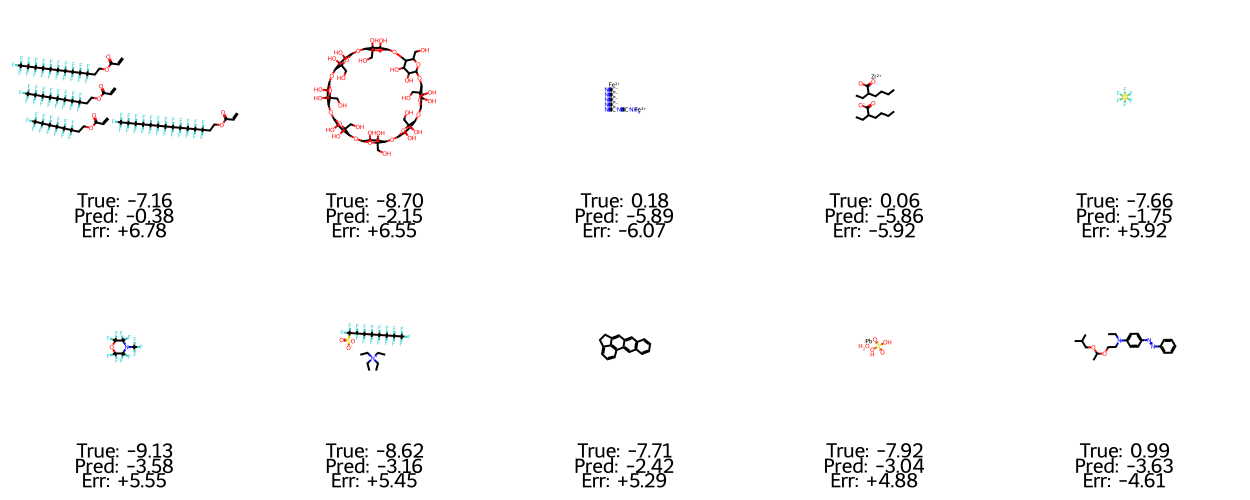

In [45]:
labels_nn = [
    f"True: {t:.2f}\nPred: {p:.2f}\nErr: {e:+.2f}"
    for t, p, e in zip(
        worst10_nn["y_true"], worst10_nn["y_pred"], worst10_nn["err"]
    )
]

opts = Draw.MolDrawOptions()
opts.legendFontSize = 20
opts.legendFraction = 0.25 

img_nn = Draw.MolsToGridImage(
    worst10_nn["mol"].tolist(),
    molsPerRow=5,
    subImgSize=(250, 250),
    legends=labels_fp,
    drawOptions=opts,
)
img_nn

# Project Summary

**Data:** AqSolDB curated aqueous solubility dataset (~10k molecules, target = experimental logS in water)

**Best model: v1: - RDKit descriptors + Random Forest**
- MAE ≈ 0.65, RMSE ≈ 0.96, R² ≈ 0.83 on a 20% validation split (random_state=42).[file:308]
- Uses ~200 RDKit descriptors with median imputation and 400‑tree RF.

**Alternative models**
- v2: Morgan fingerprints (radius 2, 2048 bits) + RF underperform descriptors (higher MAE/RMSE, lower R²), so classical RDKit descriptors remain preferable for this task.
- v3: GradientBoostingRegressor on descriptors gives slightly worse metrics than RF, confirming RF as a strong baseline.
- A small MLPRegressor on descriptors also underperforms the RF baseline, suggesting tree ensembles are a better fit for this tabular chemistry data.

**Scientific error analysis (RF)**
- Predicted vs true logS shows a tight diagonal, with largest errors for very low‑solubility compounds.
- Error vs MolLogP, TPSA, and MolWt does not reveal strong systematic bias, though variance increases for heavier and more extreme molecules.
- Highly complex chains with multiple substituents and metallic salts are least predictable by any of these methods.
- Examples:
  - 3,3,4,4,5,5,6,6,7,7,8,8,8-tridecafluorooctyl prop-2-enoate 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,10-heptadecafluorodecyl prop-2-enoate 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,12-henicosafluorododecyl prop-2-enoate 3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13,14,14,14-pentacosafluorotetradecyl prop-2-enoate
  - 2-ethylhexanoic acid, zirconium salt
  - 5-hydroxy-2-(3-hydroxy-4-methoxyphenyl)-7-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-({[(2R,3R,4R,5R,6S)-3,4,5-trihydroxy-6-methyloxan-2-yl]oxy}methyl)oxan-2-yl]oxy}-4H-chromen-4-one
  
**Takeaways**
- RDKit descriptors + RF provide a robust, interpretable baseline for AqSolDB.
- More complex models and representations (fingerprints, GBM, MLP) did not surpass this baseline under simple tuning.
- Future work could explore hyperparameter optimization, conformer‑dependent 3D descriptors, or graph neural networks.